In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
#from ccfj import GetStationPairs
from geopy.distance import great_circle
#import shapefile
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [4]:
flag_project = 1 # 0--regular; 1--repartrition

In [5]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [6]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.2_01-01/


In [7]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [8]:
dir_model_fund = dir_project + info_basic['dir_model_fund']
dir_model = dir_project + info_basic['dir_model']
dir_image = dir_project + info_basic['dir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_inv_dispernet = dir_project + info_basic['dir_inv_dispernet']
dir_partition = dir_project + info_basic['dir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '25--33-03',
 '26--34-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '33--46-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '59--35-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '66--52-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '84--35-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 

In [9]:
def GetStationPairs(nsta):
    StationPair = []
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            StationPair.append(ii)
            StationPair.append(jj)
    StationPair = np.array(StationPair,dtype=np.int32)
    return StationPair

In [10]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [11]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [12]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [13]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [14]:
inter_file = dir_inv_dispernet + 'vs_inter.npz'
inter = np.load(inter_file, allow_pickle=True)

In [15]:
vs_fund = inter['vs_fund']
vs = inter['vs']
lon_inter_in = inter['lon']
lat_inter_in = inter['lat']
z = inter['depth']
dz = inter['dz']
N = inter['N']

In [16]:
# define traces
traces = {}
for i in range(4,18):
    traces[i] = np.zeros([2,2])
    sta_start = 'R'+'20'+str(i).zfill(2)
    sta_end = 'R'+'30'+str(i).zfill(2)
    if sta_start not in stalist_all:
        print('Warning: start station %s not found' % sta_start)
    if sta_end not in stalist_all:
        print('Warning: end station %s not found' % sta_end)
    traces[i][0,0] = lon_stations_all[stalist_all.index(sta_start)]
    traces[i][0,1] = lat_stations_all[stalist_all.index(sta_start)]
    traces[i][1,0] = lon_stations_all[stalist_all.index(sta_end)]
    traces[i][1,1] = lat_stations_all[stalist_all.index(sta_end)]

In [17]:
def extract_points(tag_trace,lon_inter_in,lat_inter_in):
    global traces
    trace = traces[tag_trace]

    x1 = trace[0,0]
    y1 = trace[0,1]
    x2 = trace[1,0]
    y2 = trace[1,1]
    A = (y2-y1)/(x2-x1)
    B = -1
    C = y2 - A*x2

    flag_r = np.sqrt(( (lon_inter_in[1]-lon_inter_in[0])**2 + (lat_inter_in[1]-lat_inter_in[0])**2 ))/2
    index = []
    
    for i in range(len(lon_inter_in)):
        x0 = lon_inter_in[i]
        y0 = lat_inter_in[i]
        d = abs(A*x0+B*y0+C)/math.sqrt(A**2+B**2)
        if d <= flag_r:
            index.append(i)
    return index

In [18]:
def find_intersection_point(point1_line, point2_line, external_point):
    # 计算直线的斜率
    line_slope = (point2_line[1] - point1_line[1]) / (point2_line[0] - point1_line[0])

    # 计算直线的截距
    line_intercept = point1_line[1] - line_slope * point1_line[0]

    # 计算垂线的斜率
    perpendicular_slope = -1 / line_slope

    # 计算垂线的截距
    perpendicular_intercept = external_point[1] - perpendicular_slope * external_point[0]

    # 求解方程组以找到交点
    intersection_x = (perpendicular_intercept - line_intercept) / (line_slope - perpendicular_slope)
    intersection_y = line_slope * intersection_x + line_intercept

    return intersection_x, intersection_y

In [19]:
lon_inter_verti = {}
lat_inter_verti = {}
vs_inter_verti = {}
vs_inter_fund_verti = {}   
lon_ele_verti = {}
lat_ele_verti = {} 
ele_verti = {}
r = {}
r_ele = {}
indexes = {}
indexes_ele = {}
loc_starts = {}
loc_ele_starts = {}
for tag in traces.keys():
    index = extract_points(tag,lon_inter_in,lat_inter_in)
    indexes[tag] = index
    index_ele = extract_points(tag,lon_stations_in,lat_stations_in)
    indexes_ele[tag] = index_ele
    lon_inter_verti[tag] = np.array(lon_inter_in)[index]
    lat_inter_verti[tag] = np.array(lat_inter_in)[index]
    lon_ele_verti[tag] = np.array(lon_stations_in)[index_ele]
    lat_ele_verti[tag] = np.array(lat_stations_in)[index_ele]
    r[tag] = np.zeros(len(index))
    r[tag][0] = 0
    r_ele[tag] = np.zeros(len(index_ele))
    r_ele[tag][0] = 0
    vs_inter_verti[tag] = []
    vs_inter_fund_verti[tag] = []
    ele_verti[tag] = []
    loc_start = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][0], lat_inter_verti[tag][0]])
    loc_ele_start = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][0], lat_inter_verti[tag][0]])
    loc_starts[tag] = loc_start
    loc_ele_starts[tag] = loc_ele_start
    for i in range(N):
        vs_inter_verti[tag].append(vs[i,index])
        vs_inter_fund_verti[tag].append(vs_fund[i,index])
    ele_verti[tag].append(np.array(elevation_stations_in)[index_ele])
    for i in range(len(index)):
        if i > 0:
            loc_new = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][i], lat_inter_verti[tag][i]])
            r[tag][i] = np.sqrt((loc_new[0]-loc_start[0])**2 + (loc_new[1]-loc_start[1])**2)
    for i in range(len(index_ele)):
        if i > 0:
            loc_new = find_intersection_point(traces[tag][0], traces[tag][1], [lon_ele_verti[tag][i], lat_ele_verti[tag][i]])
            r_ele[tag][i] = np.sqrt((loc_new[0]-loc_ele_start[0])**2 + (loc_new[1]-loc_ele_start[1])**2)

In [20]:
# 判断两条线段是否相交
def cross_product(p1, p2, p3):
    """计算叉积"""
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def on_segment(p1, p2, p3):
    """检查p2是否在以p1和p3为端点的线段上"""
    return min(p1[0], p3[0]) <= p2[0] <= max(p1[0], p3[0]) and min(p1[1], p3[1]) <= p2[1] <= max(p1[1], p3[1])

def segments_intersect(p1, q1, p2, q2):
    """检查由(p1, q1)和(p2, q2)形成的两条线段是否相交"""
    # 检查线段的方向
    o1 = cross_product(p1, q1, p2)
    o2 = cross_product(p1, q1, q2)
    o3 = cross_product(p2, q2, p1)
    o4 = cross_product(p2, q2, q1)

    # 如果两条线段的方向相异，则它们相交
    if o1 * o2 < 0 and o3 * o4 < 0:
        return True
    # 特殊情况处理
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def plot_segments(p1, q1, p2, q2):
    plt.plot([p1[0], q1[0]], [p1[1], q1[1]], color='blue', label='Segment 1')
    plt.plot([p2[0], q2[0]], [p2[1], q2[1]], color='red', label='Segment 2')

    intersection = segments_intersect(p1, q1, p2, q2)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Segments Intersection')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [21]:
def find_fault_inter(tag_trace):
    global traces
    global faults
    global lon_inter_verti
    global lat_inter_verti

    lat_fault_inter = []
    lon_fault_inter = []

    for key in faults.keys():
        lon_fault = faults[key]['lon']
        lat_fault = faults[key]['lat']  
        index_fault_start = np.argmin(lon_fault)
        index_fault_end = np.argmax(lon_fault)
        p1 = [lon_fault[index_fault_start], lat_fault[index_fault_start]]
        q1 = [lon_fault[index_fault_end], lat_fault[index_fault_end]]
        index_trace_start = np.argmin(lon_inter_verti[tag_trace])
        index_trace_end = np.argmax(lon_inter_verti[tag_trace])
        p2 = [lon_inter_verti[tag_trace][index_trace_start], lat_inter_verti[tag_trace][index_trace_start]]
        q2 = [lon_inter_verti[tag_trace][index_trace_end], lat_inter_verti[tag_trace][index_trace_end]]
        
        if segments_intersect(p1, q1, p2, q2):
            # find the nearest fault point
            lon_trace = lon_inter_verti[tag_trace]
            lat_trace = lat_inter_verti[tag_trace]

            min_distance = float('inf')

            for lon1, lat1 in zip(lon_fault, lat_fault):
                for lon2, lat2 in zip(lon_trace, lat_trace):
                    distance = math.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)
                    if distance < min_distance:
                        min_distance = distance
                        lon_fault_near = lon1
                        lat_fault_near = lat1
                        lon_trace_near = lon2
                        lat_trace_near = lat2
                    
            lon_fault_inter.append( lon_trace_near )
            lat_fault_inter.append( lat_trace_near )
        
        """
        intersection = find_lines_inter(p1, q1, p2, q2)
        if intersection is not None:
            lon_fault_inter.append(intersection[0])
            lat_fault_inter.append(intersection[1])
        """
    return lon_fault_inter, lat_fault_inter

### plot 3D

In [247]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def generate_random_points(num_points):
    # 生成随机散点
    points = np.random.rand(num_points, 2) * 10  # 在[0, 10]范围内生成均匀分布的随机点
    return points

def plot_points(ax, points, color='blue'):
    # 绘制散点
    ax.scatter(points[:, 0], points[:, 1], color=color)

def minimum_bounding_rectangle(points):
    # 计算凸包
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    # 对凸包进行拟合
    rect = Polygon(hull_points).minimum_rotated_rectangle
    coords = np.array(rect.exterior.coords.xy)
    
    return coords

In [262]:
lon_stations_new = []
lat_stations_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_new.append(lat_stations_all[stalist_all.index(sta)])

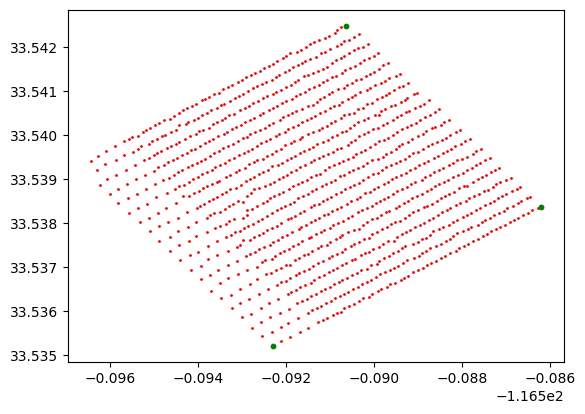

In [274]:
fig,ax = plt.subplots()
ax.scatter(lon_stations_new, lat_stations_new, c='r', label='Original',s = 1)
#ax.scatter(lon_stations_all, lat_stations_all, c='b', label='Original',s = 1)
ax.set_aspect('equal')
refs = ['R0101','R6001','R6020']
for ref in refs:
    ax.scatter(lon_stations_all[stalist_all.index(ref)], lat_stations_all[stalist_all.index(ref)], c='g', label='Original',s = 10)

In [280]:
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_new = np.array([[0,0],[600,0],[600,600]])

In [283]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [284]:
affine_matrix = compute_affine_transform(loc_refs, loc_new)

In [287]:
xx = []
yy = []
for i in range(len(lon_stations_new)):
    loc = np.array([lon_stations_new[i],lat_stations_new[i]])
    loc_new = np.dot(affine_matrix, np.append(loc, 1))
    xx.append(loc_new[0])
    yy.append(loc_new[1])

In [69]:
v_min = 0.45
v_max = 1.15

In [303]:
xx_verti = {}
yy_verti = {}
for tag in list(traces.keys()):
    xx_verti[tag] = []
    yy_verti[tag] = []
    for i in range(len(lon_inter_verti[tag])):
        loc = np.array([lon_inter_verti[tag][i],lat_inter_verti[tag][i]])
        loc_new = np.dot(affine_matrix, np.append(loc, 1))
        xx_verti[tag].append(loc_new[0])
        yy_verti[tag].append(loc_new[1])

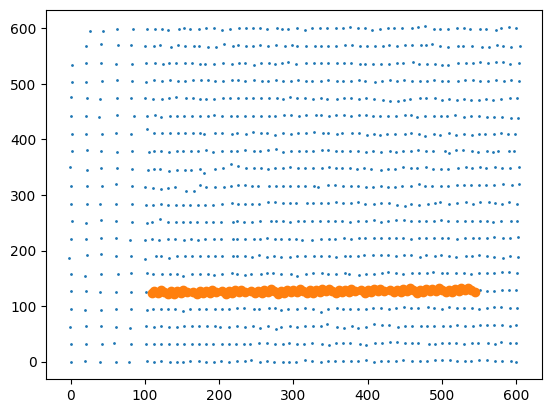

In [306]:
plt.scatter(xx,yy,s=1)
plt.scatter(xx_verti[5],yy_verti[5])

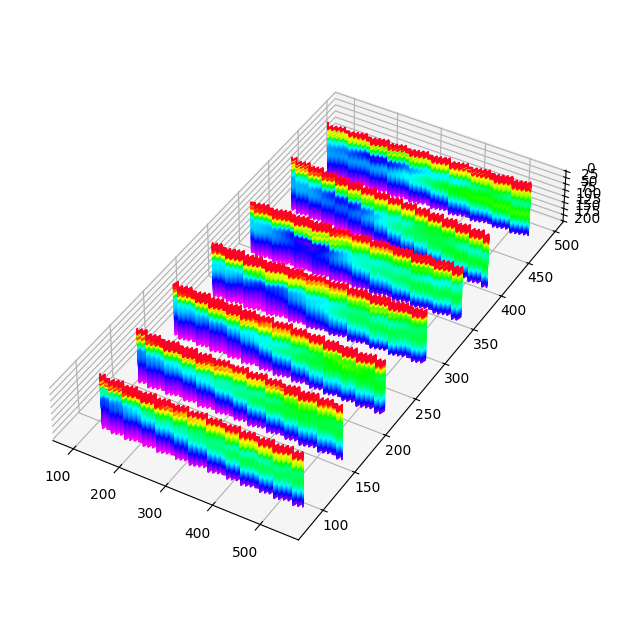

In [317]:
from matplotlib.colors import Normalize
fig = plt.figure(figsize=(40,6))
ax = fig.add_subplot(111,projection = '3d',position=[0, 0, 1, 1])
for tag in list(traces.keys())[0::2]:
    vs_this = vs_inter_verti[tag]
    x = xx_verti[tag]
    y = yy_verti[tag]
    z = z
    X,Z = np.meshgrid(x,z)
    # 设置facecolors的范围为v_min到v_max
    norm = Normalize(vmin=v_min, vmax=v_max)
    ax.plot_surface(X,y,Z,rstride=1, cstride=1, facecolors=plt.cm.gist_rainbow(norm(vs_this)), shade=False)
    # 设置z轴方向相反
#for j in range(len(faults)):
#    ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'],np.zeros_like(faults['clark'+str(j+1)]['lat']), 'k')
ax.set_zlim(ax.get_zlim()[::-1])
ax.view_init(elev=40, azim=-60)
ax.set_box_aspect([4,8,1])#
#ax.axis('off')
#plt.tight_layout()
plt.show()